In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib

from transformers import AutoTokenizer, RobertaModel
import torch
import tqdm

c:\Users\a23marmo\Desktop\Cours\venvs\intro_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Link to the text dataset: https://www.kaggle.com/datasets/danofer/dbpedia-classes
file_path = "C:/Users/a23marmo/Desktop/Cours/Intro IA/datasets/DBPedia/DBP_wiki_data.csv" # TODO: to change with yours 
folder_store_data_path = "C:/Users/a23marmo/Desktop/Cours/Intro IA/intro2ai-prof/data"
#"/home/a23marmo/Desktop/Cours/Introduction to AI/intro2ai-prof/data"

data = pd.read_csv(file_path)

In [3]:
high_level_classes = np.unique(data["l1"])
high_level_classes

array(['Agent', 'Device', 'Event', 'Place', 'Species', 'SportsSeason',
       'TopicalConcept', 'UnitOfWork', 'Work'], dtype=object)

In [4]:
data[data['l1'] == 'Species']["l3"].unique()

array(['Grape', 'Conifer', 'Fern', 'Moss', 'GreenAlga',
       'CultivatedVariety', 'Cycad', 'Arachnid', 'Fish', 'Insect',
       'Reptile', 'Mollusca', 'Bird', 'Amphibian', 'RaceHorse',
       'Crustacean', 'Fungus'], dtype=object)

In [5]:
def remove_words_from_descriptions(descriptions, words_to_remove, max_length=None):
    """
    Remove specific words from a list of descriptions and limit the length of the final description.

    Parameters:
    descriptions (list of str): List of descriptions.
    words_to_remove (list of str): List of words to remove from the descriptions.
    max_length (int, optional): Maximum length of the final description. Defaults to None.

    Returns:
    list of str: List of descriptions with the specified words removed and limited in length.
    """
    words_to_remove_set = set(words_to_remove)
    cleaned_descriptions = []

    for description in descriptions:
        cleaned_description = ' '.join(
            word for word in description.split() 
            if word.lower().strip('.,!?;:()[]{}"\'') not in words_to_remove_set
        )
        if max_length is not None:
            cleaned_description = ' '.join(cleaned_description.split()[:max_length])
        cleaned_descriptions.append(cleaned_description)

    return cleaned_descriptions

In [6]:
compute_embeddings = True

class_one = "Conifer"
class_two = "Fern"
class_three = "Moss"
class_four = "Grape"

level = "l3"

max_length=30

nb_samples = 100

class_one_stop_words = [class_one, class_two, class_three, class_four]
class_two_stop_words = [class_one, class_two, class_three, class_four]
class_three_stop_words = [class_one, class_two, class_three, class_four]
class_four_stop_words = [class_one, class_two, class_three, class_four]

all_class_one = data[data[level]==class_one]
random_class_one_subset = all_class_one.sample(n=nb_samples, random_state=42)
class_one_description = random_class_one_subset["text"].values
class_one_description = remove_words_from_descriptions(class_one_description, class_one_stop_words, max_length)

all_class_two = data[data[level]==class_two]
random_class_two_subset = all_class_two.sample(n=nb_samples, random_state=42)
class_two_description = random_class_two_subset["text"].values

class_two_description = remove_words_from_descriptions(class_two_description, class_two_stop_words, max_length)
all_class_three = data[data[level]==class_three]
random_class_three_subset = all_class_three.sample(n=nb_samples, random_state=42)
class_three_description = random_class_three_subset["text"].values
class_three_description = remove_words_from_descriptions(class_three_description, class_three_stop_words, max_length)

all_class_four = data[data[level]==class_four]
random_class_four_subset = all_class_four.sample(n=nb_samples, random_state=42)
class_four_description = random_class_four_subset["text"].values
class_four_description = remove_words_from_descriptions(class_four_description, class_four_stop_words, max_length)


In [7]:
device_general = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu") # Specify the model to make inference

# %% General model handling
def load_model(checkpoint_name="default"):
    """
    Load the HuggingFace model and tokenizer.
    """
    # Checkpoint for the model
    if checkpoint_name == "default":
        checkpoint_name = "FacebookAI/roberta-base"

    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)
    model = RobertaModel.from_pretrained(checkpoint_name).to(device_general)

    return model, tokenizer, checkpoint_name

# %% Text embedding
def embed_this_text(text, model, tokenizer, return_cls=True):
    """
    Embed the text using the BERT model.
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, max_length=512, truncation=True)

    # Cast the inputs for CPU or GPU inference
    for key, value in inputs.items():
        inputs[key] = value.to(device_general)

    # Compute the embeddings
    with torch.inference_mode():
        outputs = model(**inputs)

    # Return the CLS token only
    if return_cls:
        return outputs.last_hidden_state[:,0,:]
    
    # Return the full embedding (for each token)
    else:
        return outputs.last_hidden_state
    
def compute_embeddings(list_text, name_file_to_save, batch_size = 10):

    model, tokenizer, checkpoint_name = load_model()
    all_embeddings = []
    for i in tqdm.tqdm(range(0,len(list_text),batch_size)):

        if (i+batch_size > len(list_text)):
            text_embeddings = embed_this_text(list(list_text[i:]), model, tokenizer)
        else:
            text_embeddings = embed_this_text(list(list_text[i:i+batch_size]), model, tokenizer)

        all_embeddings.append(text_embeddings)
    np.savez_compressed(f'{folder_store_data_path}/{name_file_to_save}.npz', embeddings = np.vstack(all_embeddings))

    return np.vstack(all_embeddings)

In [8]:
if compute_embeddings:
    batch_size = 1
    # Compute the embeddings
    class_one_embeddings = compute_embeddings(class_one_description, f"{class_one.lower()}_description_embeddings", batch_size = batch_size)
    class_two_embeddings = compute_embeddings(class_two_description, f"{class_two.lower()}_description_embeddings", batch_size = batch_size)
    class_three_embeddings = compute_embeddings(class_three_description, f"{class_three.lower()}_description_embeddings", batch_size = batch_size)
    # class_four_embeddings = compute_embeddings(class_four_description, f"{class_four.lower()}_description_embeddings", batch_size = batch_size)
else:
    class_one_embeddings = np.load(f'{folder_store_data_path}/{class_one.lower()}_description_embeddings.npz')['embeddings']
    class_two_embeddings = np.load(f'{folder_store_data_path}/{class_two.lower()}_description_embeddings.npz')['embeddings']
    class_three_embeddings = np.load(f'{folder_store_data_path}/{class_three.lower()}_description_embeddings.npz')['embeddings']
    # class_four_embeddings = np.load(f'{folder_store_data_path}/{class_four.lower()}_description_embeddings.npz')['embeddings']

# # Concatenate the embeddings for different classes
# embeddings = np.concatenate([agent_embeddings, event_embeddings, place_embeddings, species_embeddings], axis=0)
# np.savez_compressed(f'{folder_store_data_path}/text_embeddings_lab2.npz', embeddings = embeddings)

c:\Users\a23marmo\Desktop\Cours\venvs\intro_ai\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [00:04<00:00, 24.59it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a

In [9]:
from sklearn.model_selection import train_test_split

# embeddings = np.concatenate([class_one_embeddings, class_two_embeddings, class_three_embeddings, class_four_embeddings], axis=0)
# labels = np.concatenate([np.zeros(class_one_embeddings.shape[0]), np.ones(class_two_embeddings.shape[0]), 2*np.ones(class_three_embeddings.shape[0]), 3*np.ones(class_four_embeddings.shape[0])])
embeddings = np.concatenate([class_one_embeddings, class_two_embeddings, class_three_embeddings], axis=0)
np.savez_compressed(f'{folder_store_data_path}/text_embeddings_lab2.npz', embeddings = embeddings)

labels = np.concatenate([np.zeros(class_one_embeddings.shape[0]), np.ones(class_two_embeddings.shape[0]), 2*np.ones(class_three_embeddings.shape[0])])

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, stratify=labels, random_state=42)

np.savez_compressed(f'{folder_store_data_path}/text_embeddings_lab2_train_test.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

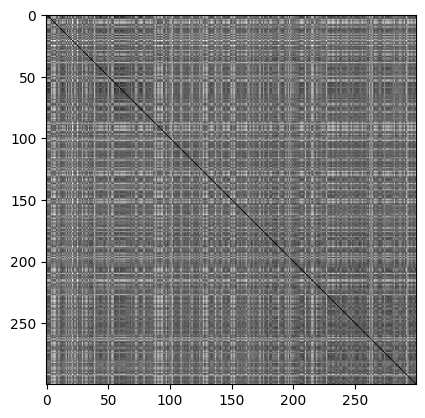

In [10]:
embeddings = np.load(f'{folder_store_data_path}/text_embeddings_lab2.npz')['embeddings']

arr = np.zeros((embeddings.shape[0],embeddings.shape[0]))
for i in range(0, embeddings.shape[0]):
    for j in range(0, embeddings.shape[0]):
        arr[i,j] = (np.linalg.norm(embeddings[i] - embeddings[j]))


import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(arr, cmap=cm.gray)


In [11]:
# Loading the data
train_test_dataset = np.load(f'{folder_store_data_path}/text_embeddings_lab2_train_test.npz')
X_train, X_test, y_train, y_test = train_test_dataset['X_train'], train_test_dataset['X_test'], train_test_dataset['y_train'], train_test_dataset['y_test']

In [12]:
# nearest class mean 
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.45      0.60        20
         1.0       0.41      0.45      0.43        20
         2.0       0.36      0.50      0.42        20

    accuracy                           0.47        60
   macro avg       0.56      0.47      0.48        60
weighted avg       0.56      0.47      0.48        60



In [28]:
from sklearn.neighbors import KNeighborsClassifier
k = 10
knn_classif = KNeighborsClassifier(n_neighbors=k, n_jobs=1)

knn_classif.fit(X_train, y_train)

y_pred_knn = knn_classif.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        20
         1.0       0.71      0.60      0.65        20
         2.0       0.68      0.75      0.71        20

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



In [13]:
from sklearn import svm

# Create a SVM classifier
svm_clf = svm.SVC(kernel='linear')

# Train the classifier
svm_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_svm = svm_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        20
         1.0       0.84      0.80      0.82        20
         2.0       0.95      0.90      0.92        20

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [17]:
from sklearn.linear_model import LogisticRegression as lr
lr_classif = lr(multi_class="ovr")

lr_classif.fit(X_train, y_train)

y_pred_lr = lr_classif.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        20
         1.0       0.88      0.75      0.81        20
         2.0       0.90      0.95      0.93        20

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



c:\Users\a23marmo\Desktop\Cours\venvs\intro_ai\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
